In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge  # stable regression baseline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# -----------------------------
# 1) Load data
# -----------------------------
DATA_PATH = "/content/social_media_engagement_data_cleaned (1).csv"
df = pd.read_csv(DATA_PATH, encoding='latin1', sep=';')

print("Rows, Columns:", df.shape)
print(df.head(3))


# -----------------------------
# 2) Identify target column
#    (tries common names; falls back if you set it manually)
# -----------------------------
candidate_targets = [
    "engagement_rate", "Engagement_Rate", "engagementRate", "EngagementRate",
    "eng_rate", "Engagement rate", "engagement rate"
]

target_col = None
for c in candidate_targets:
    if c in df.columns:
        target_col = c
        break

# If your column name is different, set it explicitly here:
# target_col = "YOUR_TARGET_COLUMN_NAME"

if target_col is None:
    raise ValueError(
        "Target column not found. Please set `target_col` manually.\n"
        f"Available columns are:\n{list(df.columns)}"
    )

print("\nUsing target column:", target_col)


# -----------------------------
# 3) Basic cleanup
#    - drop rows where target is missing
# -----------------------------
df = df.dropna(subset=[target_col]).copy()

# Optional: if engagement rate should be non-negative, enforce it conservatively
# df = df[df[target_col] >= 0].copy()

# Separate X, y
X = df.drop(columns=[target_col])
y = df[target_col].astype(float)



Rows, Columns: (5968, 28)
        post_id            timestamp day_of_week   platform        user_id  \
0  kcqbs6hxybia  2024-12-09 11:26:15      Monday  Instagram  user_52nwb0a6   
1  c9dkiomowakt  2024-09-05 21:03:01    Thursday    Twitter  user_l1vpox2k   
2  wu063ci6mizp  2025-01-27 16:09:54      Monday     Reddit  user_2es9a4lv   

               location language  \
0  Melbourne, Australia       pt   
1       Berlin, Germany       hi   
2     São Paulo, Brazil       es   

                                        text_content              hashtags  \
0  Just tried the Chromebook from Google. Best pu...                 #Food   
1  Just tried the Corolla from Toyota. Absolutely...      #Health, #Travel   
2  Just saw an ad for Coca-Cola Coke Zero during ...  #MustHave, #Discount   

                          mentions  ... comments_count impressions  \
0                              NaN  ...            701       18991   
1   @BrandSupport, @InfluencerName  ...            703       47

In [5]:
df["engagement_rate"] = df["engagement_rate"].astype(float)

if df["engagement_rate"].max() > 1:
    df["engagement_rate"] = df["engagement_rate"] / 100


In [6]:
mentions_col_to_drop = [
    'mentions'
]

X = X.drop(columns=mentions_col_to_drop)

# Re-perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42
)

print("\nTrain size after dropping 'mentions' feature:", X_train.shape)
print("Test size after dropping 'mentions' feature:", X_test.shape)

# Re-detect numeric/categorical columns
numeric_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

print("\nNumeric columns after update:", numeric_cols)
print("Categorical columns after update:", categorical_cols)


Train size after dropping 'mentions' feature: (4774, 26)
Test size after dropping 'mentions' feature: (1194, 26)

Numeric columns after update: ['sentiment_score', 'toxicity_score', 'likes_count', 'shares_count', 'comments_count', 'impressions', 'user_past_sentiment_avg', 'user_engagement_growth', 'buzz_change_rate']
Categorical columns after update: ['post_id', 'timestamp', 'day_of_week', 'platform', 'user_id', 'location', 'language', 'text_content', 'hashtags', 'keywords', 'topic_category', 'sentiment_label', 'emotion_type', 'brand_name', 'product_name', 'campaign_name', 'campaign_phase']


In [7]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop"
)

print("Preprocessing pipeline re-defined with updated numeric and categorical columns.")

Preprocessing pipeline re-defined with updated numeric and categorical columns.


In [10]:
reg_model = Ridge(alpha=1.0, random_state=42)

reg_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", reg_model)
])

reg_pipe.fit(X_train, y_train)
y_pred_reg = reg_pipe.predict(X_test)

reg_mae = mean_absolute_error(y_test, y_pred_reg)
reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))
reg_r2 = r2_score(y_test, y_pred_reg)

print("\n=== REGRESSION (Ridge) - All High-Cardinality Text Features Removed ===")
print("MAE :", reg_mae)
print("RMSE:", reg_rmse)
print("R^2 :", reg_r2)

print("\nImprovement over baseline (original):")
print("\u0394MAE :", baseline_mae - reg_mae)
print("\u0394RMSE:", baseline_rmse - reg_rmse)
print("\u0394R^2 :", reg_r2 - baseline_r2)


=== REGRESSION (Ridge) - All High-Cardinality Text Features Removed ===
MAE : 0.003629276578304722
RMSE: 0.00973430750726845
R^2 : 0.03559870340529214

Improvement over baseline (original):
ΔMAE : -0.00068148409536215
ΔRMSE: 0.00018000122367352843
ΔR^2 : 0.03599607023291995


In [9]:
dummy_model = DummyRegressor(strategy='mean')
dummy_pipe = Pipeline(steps=[('preprocess', preprocess), ('model', dummy_model)])
dummy_pipe.fit(X_train, y_train)
y_pred_dummy = dummy_pipe.predict(X_test)

baseline_mae = mean_absolute_error(y_test, y_pred_dummy)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dummy))
baseline_r2 = r2_score(y_test, y_pred_dummy)

print("\n=== BASELINE (DummyRegressor) ===")
print("MAE :", baseline_mae)
print("RMSE:", baseline_rmse)
print("R^2 :", baseline_r2)



=== BASELINE (DummyRegressor) ===
MAE : 0.002947792482942572
RMSE: 0.009914308730941979
R^2 : -0.0003973668276278097


In [11]:
fitted_preprocess = reg_pipe.named_steps["preprocess"]

feature_names = []

# Numeric feature names (unchanged)
feature_names.extend(numeric_cols)

# Categorical one-hot feature names
if len(categorical_cols) > 0:
    ohe = fitted_preprocess.named_transformers_["cat"].named_steps["onehot"]
    ohe_feature_names = ohe.get_feature_names_out(categorical_cols).tolist()
    feature_names.extend(ohe_feature_names)

coefs = reg_pipe.named_steps["model"].coef_

# Safety check
if len(coefs) != len(feature_names):
    print("\nWARNING: coefficient length != feature name length.")
    print("coef len:", len(coefs), "feature names len:", len(feature_names))

feat_df_final = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs,
    "abs_importance": np.abs(coefs)
}).sort_values("abs_importance", ascending=False)

FEATURE_PATH_FINAL = "v_ml_features_final.csv"
feat_df_final.to_csv(FEATURE_PATH_FINAL, index=False)
print(f"\nSaved final feature importance to: {FEATURE_PATH_FINAL}")

print("\nTop 15 features by absolute importance (final updated model):")
print(feat_df_final.head(15))


Saved final feature importance to: v_ml_features_final.csv

Top 15 features by absolute importance (final updated model):
                                                 feature  coefficient  \
8002                       timestamp_2024-12-30 21:31:52     0.044687   
9781                               user_id_user_1r1zn4lc     0.044687   
3996                                post_id_u50pnlesq1y8     0.044687   
19121  text_content_What's your opinion about Microso...     0.044687   
25484                   keywords_value, luxury, reliable     0.037624   
8498                       timestamp_2025-02-07 18:46:29     0.037624   
12223                              user_id_user_k9fjjzk5     0.037624   
2656                                post_id_k508grdqqbne     0.037624   
16158  text_content_Has anyone else experienced conne...     0.037624   
24425                     keywords_reliable, traditional     0.031913   
545                                 post_id_3wrr5osp1d7v     0.029183   
1

In [12]:
pred_out_final = X_test.copy()
pred_out_final["actual_engagement_rate"] = y_test.values
pred_out_final["pred_ridge_final"] = y_pred_reg
pred_out_final["error_ridge_final"] = pred_out_final["actual_engagement_rate"] - pred_out_final["pred_ridge_final"]
pred_out_final["abs_error_ridge_final"] = np.abs(pred_out_final["error_ridge_final"])

# Put key columns first
cols_first_final = [
    "actual_engagement_rate",
    "pred_ridge_final",
    "error_ridge_final",
    "abs_error_ridge_final"
]
pred_out_final = pred_out_final[cols_first_final + [c for c in pred_out_final.columns if c not in cols_first_final]]

PRED_PATH_FINAL = "ml_predictions_final.csv"
pred_out_final.to_csv(PRED_PATH_FINAL, index=False)
print(f"\nSaved final predictions to: {PRED_PATH_FINAL}")


Saved final predictions to: ml_predictions_final.csv


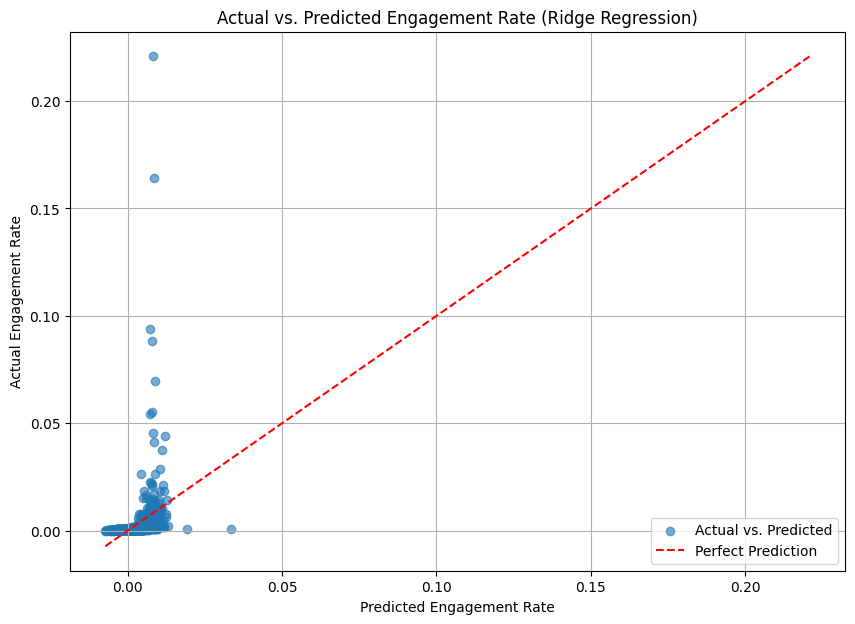

Scatter plot showing actual vs. predicted engagement rates generated.


In [13]:
import matplotlib.pyplot as plt

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 7))
plt.scatter(pred_out_final['pred_ridge_final'], pred_out_final['actual_engagement_rate'], alpha=0.6, label='Actual vs. Predicted')

# Add a line for perfect predictions (y=x)
# Determine the min and max for the diagonal line
min_val = min(pred_out_final['actual_engagement_rate'].min(), pred_out_final['pred_ridge_final'].min())
max_val = max(pred_out_final['actual_engagement_rate'].max(), pred_out_final['pred_ridge_final'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

# Set labels and title
plt.xlabel('Predicted Engagement Rate')
plt.ylabel('Actual Engagement Rate')
plt.title('Actual vs. Predicted Engagement Rate (Ridge Regression)')

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()
print("Scatter plot showing actual vs. predicted engagement rates generated.")

/tmp/ipython-input-3938519979.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_features['short_feature'] = top_10_features['feature'].apply(shorten_feature_name)


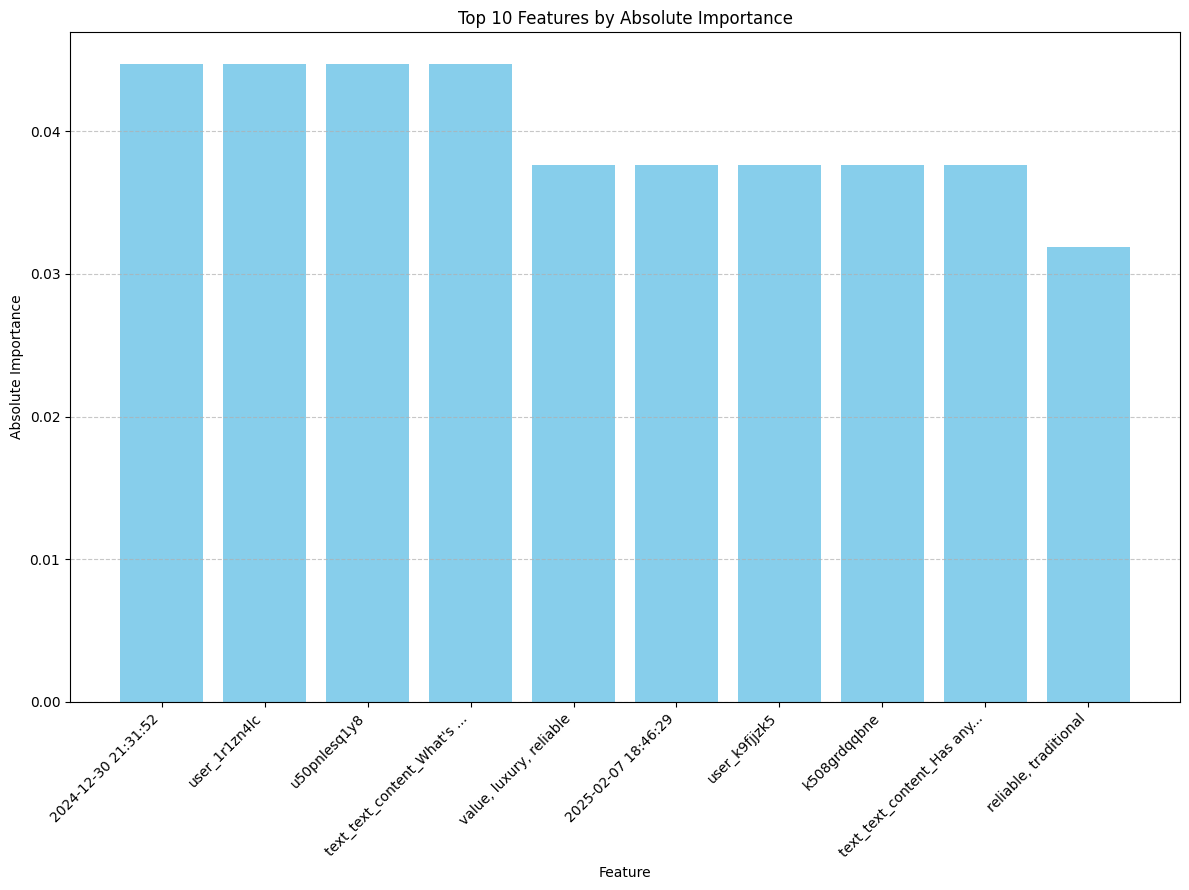

Bar chart showing top 10 feature importances generated.


In [14]:
import matplotlib.pyplot as plt

# Select the top 10 features by absolute importance
top_10_features = feat_df_final.head(10)

def shorten_feature_name(feature_name):
    # List of common prefixes to remove for one-hot encoded features
    prefixes_to_remove = [
        'timestamp_',
        'user_id_',
        'post_id_',
        'keywords_',
        'day_of_week_',
        'platform_',
        'location_',
        'language_',
        'hashtags_',
        'topic_category_',
        'sentiment_label_',
        'emotion_type_',
        'brand_name_',
        'product_name_',
        'campaign_name_',
        'campaign_phase_'
    ]

    shortened_name = feature_name
    for prefix in prefixes_to_remove:
        if shortened_name.startswith(prefix):
            shortened_name = shortened_name[len(prefix):]
            break # Only remove one prefix

    # Special handling for text_content, as the content itself can be long
    if feature_name.startswith('text_content_'):
        shortened_name = 'text_' + shortened_name[:20] + ('...' if len(shortened_name) > 20 else '')

    return shortened_name

# Apply the shortening function to the 'feature' column
top_10_features['short_feature'] = top_10_features['feature'].apply(shorten_feature_name)

# Create the bar chart, increasing figure height for better label readability
plt.figure(figsize=(12, 9)) # Increased height from 7 to 9
plt.bar(top_10_features['short_feature'], top_10_features['abs_importance'], color='skyblue')

# Set labels and title
plt.xlabel('Feature')
plt.ylabel('Absolute Importance')
plt.title('Top 10 Features by Absolute Importance')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout and display the plot
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("Bar chart showing top 10 feature importances generated.")

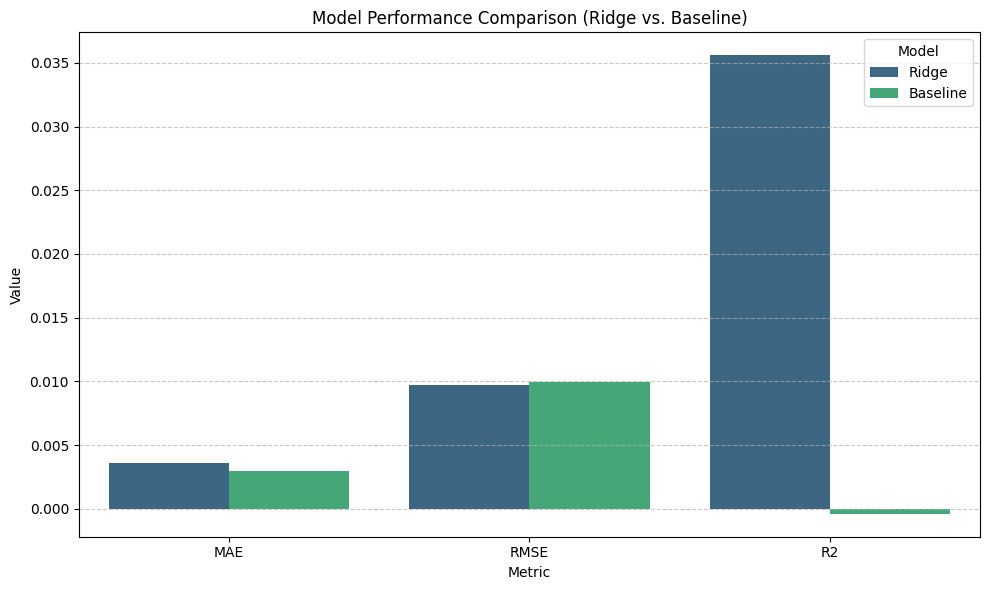

Bar chart comparing R2, RMSE, and MAE for Ridge and Baseline models generated.


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Prepare the metrics data
metrics_data = {
    'Metric': ['MAE', 'RMSE', 'R2', 'MAE', 'RMSE', 'R2'],
    'Model': ['Ridge', 'Ridge', 'Ridge', 'Baseline', 'Baseline', 'Baseline'],
    'Value': [
        reg_mae,
        reg_rmse,
        reg_r2,
        baseline_mae,
        baseline_rmse,
        baseline_r2
    ]
}

metrics_df = pd.DataFrame(metrics_data)

# Create the grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=metrics_df, palette='viridis')

# Set labels and title
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Model Performance Comparison (Ridge vs. Baseline)')

# Add legend
plt.legend(title='Model')

# Display the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Bar chart comparing R2, RMSE, and MAE for Ridge and Baseline models generated.")